In [1]:
import requests
import pandas as pd
import json
from hdx.location.country import Country
import numpy as np

In [2]:
# ! pip3 install hdx-python-country --user

In [6]:
MARKETPLACES = []
with open("marketplaces_xyz.csv") as fin: #list of 1000+ marketplaces filtered by xyz
    for line in fin:
        MARKETPLACES.append(line.split(',')[0])
MARKETPLACES[0:10]

FileNotFoundError: [Errno 2] No such file or directory: './output_files/marketplaces_xyz.csv'

### For each marketplace, where it is most prominent / popular 

In [7]:
FNAMES = %sx ls ./../indexing/search_diffkeys_byloc/
FNAMES = ["./../indexing/search_diffkeys_byloc/" + x for x in FNAMES]

raw_data = []

for FNAME in FNAMES:
    loc_code = FNAME.split("proxy")[1].split("_")[0]
    region_name = Country.get_country_info_from_iso2(loc_code)['#region+name+preferred+sub']
    raw_data.extend(json_to_result_tuples(FNAME, loc=loc_code, region=region_name))
    
df = pd.DataFrame(raw_data)
df

IndexError: list index out of range

In [7]:
def set_simple_rank(x):
    if x <= 10:
        return 3 #3 if in top 10
    if x<=100:
        return 2 #2 if in top 100
    return 1 # > 100

df['rank_simplified'] = df['search_rank'].apply(set_simple_rank)
df

,engine,keywords,language,website,loc_code,loc_region,search_rank,rank_simplified
0,baidu,io games,english,www.cxyzdaily.com.cn,AL,Southern Europe,1,3
1,baidu,io games,english,www.baidu.com,AL,Southern Europe,2,3
2,baidu,io games,english,www.baidu.com,AL,Southern Europe,3,3
3,baidu,io games,english,www.cxyzdaily.com.cn,AL,Southern Europe,4,3
4,baidu,io games,english,www.xinhuanet.com,AL,Southern Europe,5,3
...,...,...,...,...,...,...,...,...
24980,google,io games,english,blockly.games,ZA,Sub-Saharan Africa,94,2
24981,google,io games,english,www.teachyourmonstertoread.com,ZA,Sub-Saharan Africa,95,2
24982,google,io games,english,www.utomik.com,ZA,Sub-Saharan Africa,96,2
24983,google,io games,english,www.drakensang.com,ZA,Sub-Saharan Africa,97,2


Get number of files per region

In [10]:
nfiles_per_region = {}

for FNAME in FNAMES:
    loc_code = FNAME.split("proxy")[1].split("_")[0]
    region_name = Country.get_country_info_from_iso2(loc_code)['#region+name+preferred+sub']
    if region_name not in nfiles_per_region:
        nfiles_per_region[region_name] = 1
    else:
        nfiles_per_region[region_name] += 1
nfiles_per_region

{'Australia and New Zealand': 16,
 'Central Asia': 17,
 'Eastern Asia': 39,
 'Eastern Europe': 67,
 'Latin America and the Caribbean': 105,
 'Northern Africa': 11,
 'Northern America': 23,
 'Northern Europe': 15,
 'South-eastern Asia': 78,
 'Southern Asia': 51,
 'Southern Europe': 42,
 'Sub-Saharan Africa': 71,
 'Western Asia': 43,
 'Western Europe': 32}

In [11]:
#only keep marketplaces filtered by xyz
df_filtered = df[df['website'].isin(MARKETPLACES)]

#annotate the world area where the mps are most prominent 
df_filtered['top_area'] = df_filtered['website'].apply(annotate_popularity_mp)

#as line above, but also consider the rank of a website in the search results
df_filtered['top_area_method2'] =  df_filtered['website'].apply(annotate_popularity_mp2)

df_filtered

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,engine,keywords,language,website,loc_code,loc_region,search_rank,rank_simplified,top_area,top_area_method2
18,baidu,io games,english,www.wowsomegames.com,AL,Southern Europe,10,3,Central Asia,Central Asia
19,baidu,io games,english,www.bgames.com,AL,Southern Europe,1,3,Australia and New Zealand,Eastern Asia
24,baidu,io games,english,www.armorgames.com,AL,Southern Europe,6,3,Northern Europe,Northern Europe
28,baidu,io games,english,www.gameduell.com,AL,Southern Europe,10,3,Northern Europe,Northern Europe
96,baidu,io games,english,iogames.space,AU,Australia and New Zealand,1,3,Northern Africa,Northern Africa
...,...,...,...,...,...,...,...,...,...,...
24958,google,io games,english,www.freeonlinegames.com,ZA,Sub-Saharan Africa,72,2,Northern Africa,Northern Africa
24976,google,io games,english,learnenglishkids.britishcouncil.org,ZA,Sub-Saharan Africa,90,2,Australia and New Zealand,Australia and New Zealand
24979,google,io games,english,1000webgames.com,ZA,Sub-Saharan Africa,93,2,Central Asia,Central Asia
24980,google,io games,english,blockly.games,ZA,Sub-Saharan Africa,94,2,Northern Europe,Northern Europe


### For each area, what are the most prominent / popular marketplaces

In [65]:
for region in df_filtered['loc_region'].unique():
    df_reg = df_filtered[df_filtered['loc_region']==region]
    df_reg_aggr = df_reg.groupby("website")['engine'].count().sort_values(ascending=False)
    
    total = df_reg_aggr.values.sum()
    print('\n',region, '\n', df_reg_aggr.index[0], str(df_reg_aggr.values[0]*100/total)[0:4]+'%', 
                  df_reg_aggr.index[1], str(df_reg_aggr.values[1]*100/total)[0:4]+'%',
                  df_reg_aggr.index[2], str(df_reg_aggr.values[2]*100/total)[0:4]+'%',
                  df_reg_aggr.index[3], str(df_reg_aggr.values[3]*100/total)[0:4]+'%',
                  df_reg_aggr.index[4], str(df_reg_aggr.values[4]*100/total)[0:4]+'%')


 Southern Europe 
 www.agame.com 5.19% www.crazygames.com 4.40% www.gamesgames.com 3.93% www.kongregate.com 3.77% www.addictinggames.com 3.30%

 Australia and New Zealand 
 www.agame.com 6.05% www.addictinggames.com 5.09% www.crazygames.com 4.14% www.miniclip.com 3.82% www.freeonlinegames.com 3.50%

 Southern Asia 
 www.agame.com 4.31% www.gamesgames.com 3.82% www.crazygames.com 3.57% www.arkadium.com 3.08% www.miniclip.com 3.08%

 Latin America and the Caribbean 
 www.agame.com 3.75% www.kongregate.com 3.31% www.arkadium.com 3.15% www.addictinggames.com 2.99% www.miniclip.com 2.82%

 Northern America 
 www.agame.com 4.50% www.crazygames.com 3.08% www.addictinggames.com 3.08% www.kongregate.com 3.08% www.arkadium.com 2.84%

 Western Europe 
 zone.msn.com 3.14% www.kongregate.com 2.98% www.miniclip.com 2.51% www.freeonlinegames.com 2.51% www.agame.com 2.35%

 Northern Europe 
 www.kongregate.com 5.26% www.games.co.uk 3.75% www.freeonlinegames.com 3.75% www.arkadium.com 3.75% www.agame.

### CDFs discussed with xyz: how many locations per marketplace

In [2]:
FNAMES = %sx ls ./../indexing/search_diffkeys_byloc/
FNAMES = ["./../indexing/search_diffkeys_byloc/" + x for x in FNAMES]

FNAMES2 = %sx ls ./../indexing/search_diffkeys_byloc_17-08-2020/
FNAMES2 = ["./../indexing/search_diffkeys_byloc_17-08-2020/" + x for x in FNAMES2]

FNAMES3 = %sx ls ./../indexing/search_diffkeys_byloc_21-08-2020/
FNAMES3 = ["./../indexing/search_diffkeys_byloc_21-08-2020/" + x for x in FNAMES3]

FNAMES = FNAMES + FNAMES2 + FNAMES3

In [9]:
raw_data = []

for FNAME in FNAMES:
    loc_code = FNAME.split("proxy")[1].split("_")[0]
    region_name = Country.get_country_info_from_iso2(loc_code)['#region+name+preferred+sub']
    raw_data.extend(json_to_result_tuples(FNAME, loc=loc_code, region=region_name))
    
df = pd.DataFrame(raw_data)

,engine,keywords,language,website,loc_code,loc_region,search_rank
0,baidu,io games,english,www.cxyzdaily.com.cn,AL,Southern Europe,1
1,baidu,io games,english,www.baidu.com,AL,Southern Europe,2
2,baidu,io games,english,www.baidu.com,AL,Southern Europe,3
3,baidu,io games,english,www.cxyzdaily.com.cn,AL,Southern Europe,4
4,baidu,io games,english,www.xinhuanet.com,AL,Southern Europe,5
...,...,...,...,...,...,...,...
184354,google,io games,english,www.nitrome.com,US,Northern America,95
184355,google,io games,english,www.websudoku.com,US,Northern America,96
184356,google,io games,english,www.spellingshed.com,US,Northern America,97
184357,google,io games,english,us-en.superbook.cbn.com,US,Northern America,98


In [11]:
df_filtered = df[df['website'].isin(MARKETPLACES)]
df_filtered

,engine,keywords,language,website,loc_code,loc_region,search_rank
18,baidu,io games,english,www.wowsomegames.com,AL,Southern Europe,10
19,baidu,io games,english,www.bgames.com,AL,Southern Europe,1
24,baidu,io games,english,www.armorgames.com,AL,Southern Europe,6
28,baidu,io games,english,www.gameduell.com,AL,Southern Europe,10
96,baidu,io games,english,iogames.space,AU,Australia and New Zealand,1
...,...,...,...,...,...,...,...
184335,google,io games,english,learnenglishkids.britishcouncil.org,US,Northern America,76
184339,google,io games,english,www.playstation.com,US,Northern America,80
184348,google,io games,english,lol.disney.com,US,Northern America,89
184349,google,io games,english,www.mmorpg.com,US,Northern America,90


/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


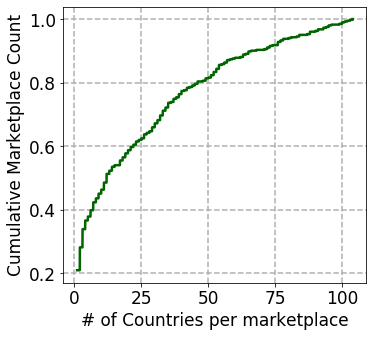

In [28]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', size=17)
plt.rcParams["figure.figsize"] = (5.5,5.0)

    
#IMP !! Labels are swapped here!
num_bins = 100000
data = df_filtered.groupby('website')['loc_code'].nunique().values #number of unique locations per website 



counts, bin_edges = np.histogram (data , bins=num_bins, normed=True)
cdf = np.cumsum (counts)
a, = plt.plot (bin_edges[1:], cdf/cdf[-1], lw=2.5, color='darkgreen', linestyle='-')

plt.xlabel("# of Countries per marketplace")
plt.ylabel("Cumulative Marketplace Count")
# plt.xticks([0,0.1,0.2,0.3,0.4])
# plt.xlim([0,0.45])
# plt.legend(handles=[a, b, c], loc=4, frameon=False)
plt.grid(lw=1.5, linestyle='--')
# plt.xscale('log')
plt.tight_layout()
plt.savefig("cdf_locations_per_website.pdf")
plt.show()


### CDFs discussed with xyz: how many marketplaces per location

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


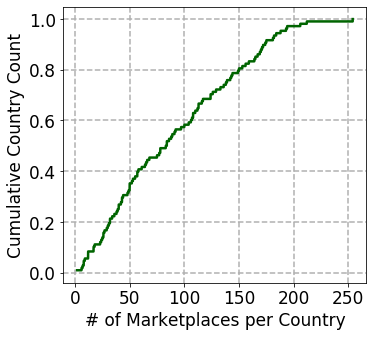

In [26]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', size=17)
plt.rcParams["figure.figsize"] = (5.5,5.0)

    
#IMP !! Labels are swapped here!
num_bins = 100000
data = df_filtered.groupby('loc_code')['website'].nunique().values #number of unique websites per location



counts, bin_edges = np.histogram (data , bins=num_bins, normed=True)
cdf = np.cumsum (counts)
a, = plt.plot (bin_edges[1:], cdf/cdf[-1], lw=2.5, color='darkgreen', linestyle='-')

plt.xlabel("# of Marketplaces per Country")
plt.ylabel("Cumulative Country Count")
plt.xticks([0,50,100,150,200,250])
# plt.xlim([0,0.45])
# plt.legend(handles=[a, b, c], loc=4, frameon=False)
plt.grid(lw=1.5, linestyle='--')
# plt.xscale('log')
plt.tight_layout()
plt.savefig("cdf_websites_per_location.pdf")
plt.show()

### LIBRARY

In [8]:
#convert json search results in list of tuples 
def json_to_result_tuples(json_file, lan="english", loc='', region=''):
    engine = json_file.split('/')[-1].split("_")[0]
    results_from_json = []
    with open(json_file) as f:
        data = json.load(f)
    n_res = len(data)
    for tup in data:
        #extract website
        if tup['url'][0:8] == "https://":
            website = tup['url'].split("https://")[1].split("/")[0]
        elif tup['url'][0:7] == "http://":
            website = tup['url'].split("http://")[1].split("/")[0]
        else:
            continue

        #add tuple (add "score" value e.g., rank1-->100, rank2-->99, etc..)
        results_from_json.append ({'engine':engine,
                            'keywords': "io games",
                            'language':lan,
                            'website':website,
                            'loc_code':loc,
                            'loc_region':region,
                            'search_rank':tup['rank']})
#                             'search_score': 1-tup['rank']/n_res}) #relative
    return results_from_json

In [7]:
#standard: only count occurrences of the website in search results
def annotate_popularity_mp(mp):
    df_mp = df_filtered[df_filtered['website']==mp]
    df_mp_aggr = df_mp.groupby('loc_region')['website'].count()
    
    res = []
    for i,x in zip(df_mp_aggr.index, df_mp_aggr.values):
        res.append([i,x, x/nfiles_per_region[i]]) #normalized by number of files per region
    res_sorted = sorted(res, key = lambda x: x[2], reverse=True)
    return res_sorted[0][0] #the area where the marketplace is ``most" prominent based on search results


#occurrences plus +1 bonus if in top10 search results
def annotate_popularity_mp2(mp):
    df_mp = df_filtered[df_filtered['website']==mp]
    df_mp_aggr = df_mp.groupby('loc_region')['rank_simplified'].sum()
    
    res = []
    for i,x in zip(df_mp_aggr.index, df_mp_aggr.values):
        res.append([i,x, x/nfiles_per_region[i]]) #normalized by number of files per region
    res_sorted = sorted(res, key = lambda x: x[2], reverse=True)
    return res_sorted[0][0] #the area where the marketplace is ``most" prominent based on search results